<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/Unet_testsizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim

import glob
from torchvision.transforms import v2

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)


        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))


        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Up-convolutions
        xup1 = self.upconv1(xe52)

        xcat = torch.cat([xup1, xe42], dim=1)

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)

        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        xcat3 = torch.cat([xup3, xe22], dim=1)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=1)

        return output

In [ ]:

net=UNet(n_class=3) #running model

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

#image=cv2.imread('SOCprist0001.tiff',cv2.IMREAD_GRAYSCALE)

#print(net(transform(image[0:128,0:128])))

In [ ]:
#Setting up hyper parameters, from exercise week 6

LEARNING_RATE = 0.001
loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.
#loss_fn =  nn.BCEWithLogitsLoss()         # <-- Your code here.

def accuracy(ys, ts):
    correct_prediction = torch.eq(ys, ts)
    return torch.mean(correct_prediction.float())

In [ ]:
class SOCDataset(Dataset):
    def __init__(self, root_dir, transform=None,subimage_size=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform
        self.subimage_size=subimage_size

        self.image_filenames = [f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][:100]
        self.label_filenames = [f for f in os.listdir(self.label_folder) if f.endswith('.tif')][:100]

    def __len__(self):
        return len(self.image_filenames)

    def split_image(self, image):
        h, w = image.shape
        subimages = []
        for i in range(0, h, self.subimage_size):
            for j in range(0, w, self.subimage_size):
                subimage = image[i:i + self.subimage_size, j:j + self.subimage_size]

                if subimage.shape==(self.subimage_size,self.subimage_size):
                  subimages.append(subimage)
        return torch.stack(subimages)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])
      label_name = os.path.join(self.label_folder, self.label_filenames[idx])


      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      subimages = self.split_image(torch.Tensor(image))

      if self.transform:
          subimages = self.transform(subimages)

      return subimages, self.transform(torch.Tensor(label).numpy())

In [ ]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  # subtract 0.5 and divide by 0.5

    ]
)


In [ ]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive//AI data/', transform = transform,subimage_size=56)

len(SOC_dataset)

100

In [ ]:
a = torch.arange(128*128).reshape(128, 128)



RuntimeError: ignored

In [ ]:
len(SOC_dataset)

100

In [ ]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
BATCH_SIZE = 24
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(SOC_dataset)),
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(SOC_dataset, train_indices)
test_split = Subset(SOC_dataset, test_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

In [ ]:
net=UNet(n_class=3)

optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.95)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

batch_size = 24
num_epochs = 12 #changing the num_epochs from 2 to 12
validation_every_steps = 10

step = 0
net.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        # Compute loss.
        targets[targets==0]=0
        targets[targets==128]=1
        targets[targets==255]=2

        targets = targets.to(torch.int64)[:,0:128,0:128]

        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = torch.argmax(output,dim=1)
        train_accuracies_batches.append(accuracy(predictions,targets))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)


                    targets[targets==0]=0
                    targets[targets==128]=1
                    targets[targets==255]=2

                    targets = targets.to(torch.int64)[:,0:128,0:128]

                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(predictions, targets))

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

ValueError: ignored

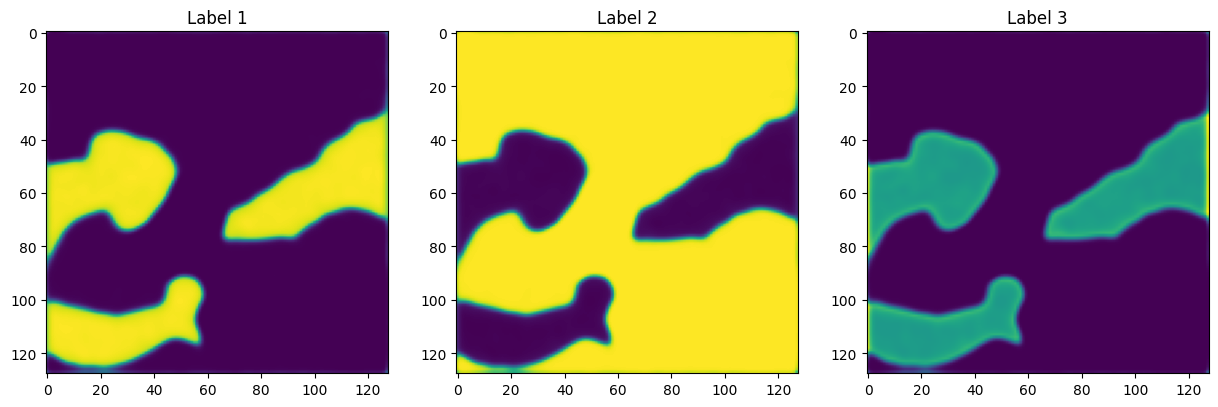

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(output.detach().numpy()[0,0,:,:])
axs[0].set_title('Label 1')
axs[1].imshow(output.detach().numpy()[0,1,:,:])
axs[1].set_title('Label 2')
axs[2].imshow(output.detach().numpy()[0,2,:,:])
axs[2].set_title('Label 3')

# Create a common colorbar
#cax = fig.add_axes([0.93, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar

# You can use any of the axes to create the colorbar; here, I've used axs[2]


# Set the label for the colorbar

plt.show()

In [ ]:
np.max(output.detach().numpy()[0,2,:,:])

0.08506861

NameError: ignored

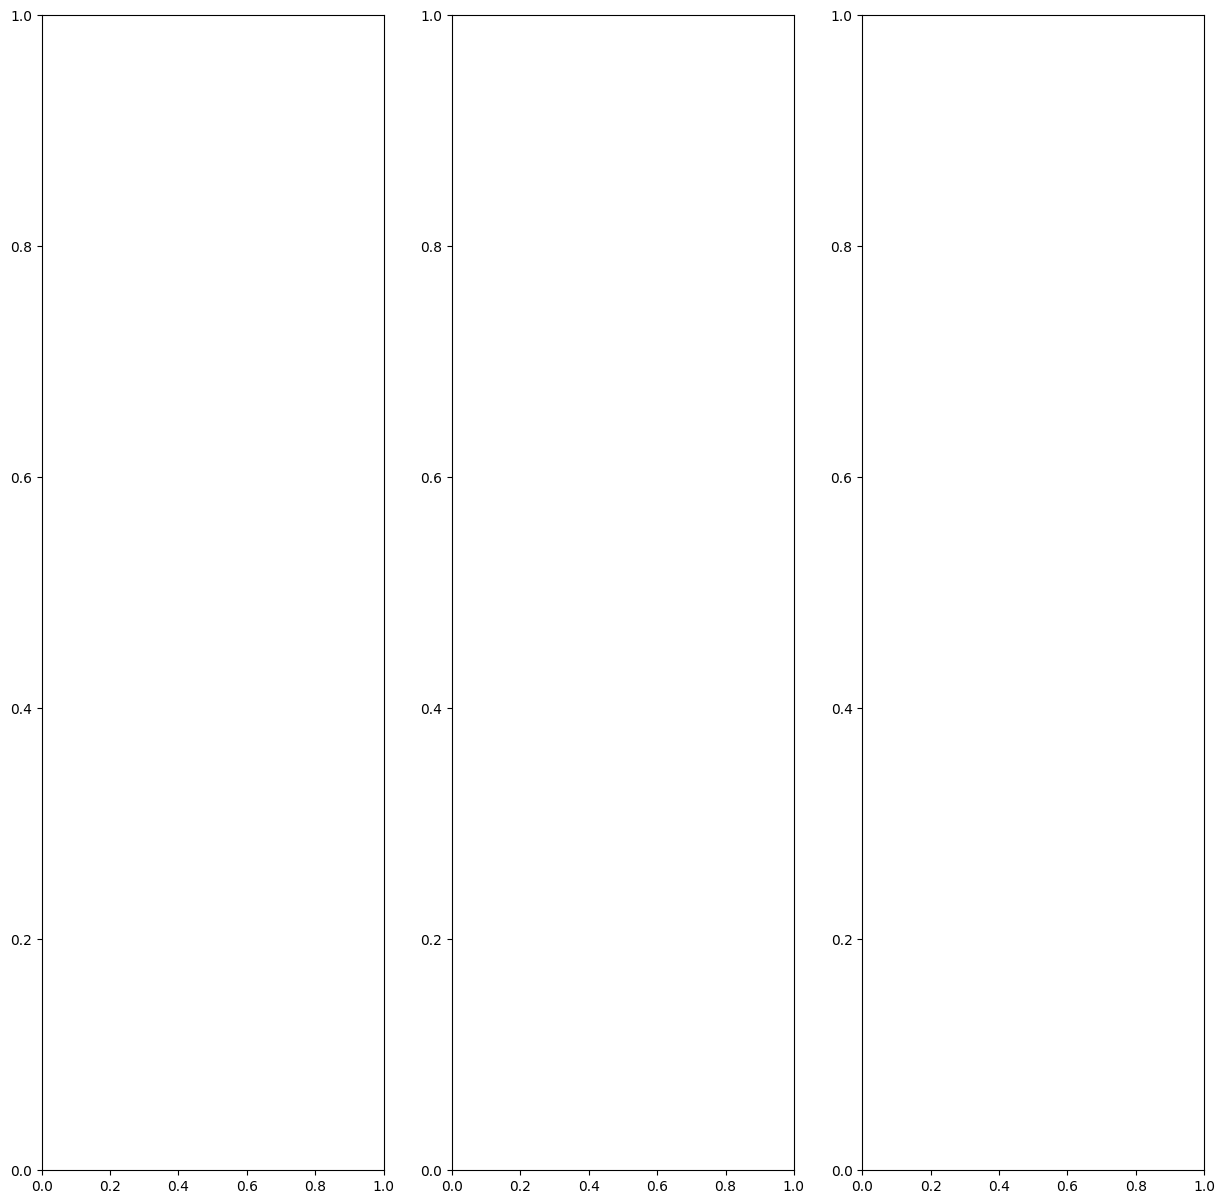

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(im_true[0,:,:].detach().numpy())
axs[0].set_title('Label 1')
axs[1].imshow(im_true[1,:,:].detach().numpy())
axs[1].set_title('Label 2')
axs[2].imshow(im_true[2,:,:].detach().numpy())
axs[2].set_title('Label 3')

